In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [65]:
# !pip install statsmodels

In [4]:
df = pd.read_excel("../data/brote_dengue.xlsx")
df.columns = ["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","brote","Dengue"]
df = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max","Dengue"]]
df = df.dropna()
df

,Temp_Seca_Max,Precipitacion,Temp_Seca_Min,Hum_Rel_Min,Hum_Rel_Max,Dengue
0,25.866667,3.700000,19.433333,47.500000,91.666667,2
1,28.200000,0.000000,20.800000,40.833333,91.333333,2
2,29.066667,0.033333,20.933333,45.333333,94.333333,1
3,30.266667,11.133333,20.500000,57.833333,92.000000,1
4,28.133333,1.016667,18.600000,50.833333,89.166667,2
...,...,...,...,...,...,...
93,28.200000,2.783333,20.066667,46.833333,86.500000,22
94,27.066667,7.050000,20.966667,49.500000,87.666667,18
95,28.933333,4.350000,20.933333,44.166667,87.666667,17
96,29.933333,0.733333,20.700000,45.000000,87.500000,14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


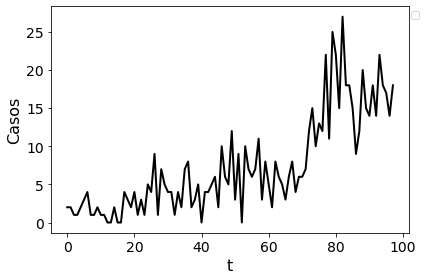

In [10]:
values = df.Temp_Seca_Max.values
xx = np.arange(values.shape[0])
plt.plot(xx,df["Dengue"].values, 
         c="k",
        #  marker = 'o',
         linewidth=2,
         markersize=6
         )

plt.legend(bbox_to_anchor = (1.04,1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('t', fontsize = 16)    
plt.ylabel('Casos', fontsize = 16)  
plt.tight_layout()
plt.savefig("outputs/series_casos_dengue.pdf", dpi = 200)
plt.show()

In [89]:
def linear_regressor_with(df,slag, seed = 42, shuffle = True):
    X = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max"]].values
    y = df["Dengue"].values

    n_samples,n_features = X.shape

    #Se hace el ventaneo para obtener los datos de entrenamiento
    new_X = []
    for i in range(0,n_samples - slag ):
        X_raveled = X[i:i+slag,:].ravel()
        new_X.append(X_raveled)
    new_X = np.array(new_X)
    new_y = y[slag:]

    print(f'Utilizando un Slag de {slag} tenemos X: {new_X.shape} y: {new_y.shape}')
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, 
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    ind_train, ind_test = train_test_split(np.arange(new_X.shape[0]),
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    
    #Estadistico
    # est = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    # print(est.summary())
    
    #Sklearn
    print(f'Test (20%): {X_test.shape[0]}')
    
    #train
    clf = LinearRegression().fit(X_train, y_train)    
    score_train = clf.score(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    score_train_adjusted = 1 - ( 1-score_train ) * ( y_train.shape[0] - 1 ) / ( y_train.shape[0] - X_train.shape[1] - 1 )
    print(f'score during training: {score_train} || Adjusted: {score_train_adjusted} || MSE: {mean_squared_error(y_train,y_train_pred)}')
    
    
    #test
    y_test_pred = clf.predict(X_test)
    score_test = clf.score(X_test, y_test)
    mse = mean_squared_error(y_test,y_test_pred)
    print(f'score during test: {score_test} || MSE: {mse}')
    # score_test_adjusted = 1 - ( 1-score_test ) * ( y_test.shape[0] - 1 ) / ( y_test.shape[0] - X_test.shape[1] - 1 )
    # print(f'score during test: {score_test} || Adjusted: {score_test_adjusted}')
    
    coefs = clf.coef_
    # print(.shape)
    return ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, score_train_adjusted, mse

Utilizando un Slag de 7 tenemos X: (91, 35) y: (91,)
Test (20%): 19
score during training: 0.5583066577095429 || Adjusted: 0.12888257492715405 || MSE: 7.437897764002266
score during test: -9.177521465031134 || MSE: 188.89028757814017


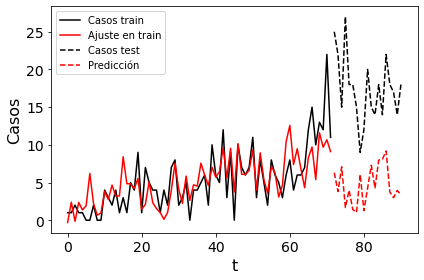

In [92]:
ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, r2, mse = linear_regressor_with(df,7,shuffle=False)

plt.plot(ind_train,y_train, c="k", label="Casos train")
plt.plot(ind_train,y_train_pred, c="r", label = "Ajuste en train")

plt.plot(ind_test,y_test, c="k", linestyle="--", label = "Casos test")
plt.plot(ind_test,y_test_pred, c="r", linestyle="--", label = "Predicción")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('t', fontsize = 16)    
plt.ylabel('Casos', fontsize = 16)  
plt.tight_layout()
plt.legend()
plt.savefig("outputs/linearReg_lag7.pdf", dpi = 200)

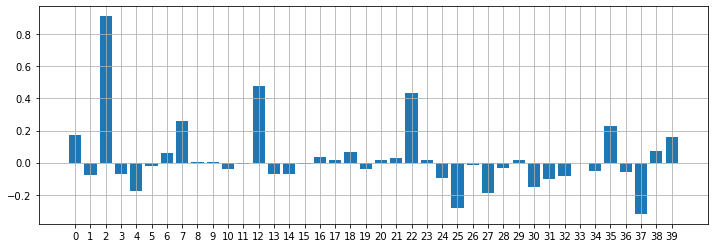

In [57]:
fig, ax = plt.subplots(figsize = (12,4))
xx = np.arange(coefs.shape[0])
plt.grid()
plt.bar(xx,coefs / coefs.sum())
ax.set_xticks(xx)
plt.show()

In [58]:
def linear_regressor_with(df,slag, seed = 42, shuffle = True):
    X = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max"]].values
    y = df["Dengue"].values

    n_samples,n_features = X.shape

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)    
    ind_train, ind_test = train_test_split(np.arange(X.shape[0]),
                                                        test_size=0.20, 
                                                        random_state=seed,
                                                        shuffle = shuffle)
    
    #Estadistico
    est = sm.OLS(y_train,sm.add_constant(X_train)).fit()
    print(est.summary())

    print(f'Test (20%): {X_test.shape[0]}')
    clf = LinearRegression().fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    print(f'score during training: {score_train}')
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    score_test = clf.score(X_test, y_test)
    print(f'score during test: {score_test}')
    coefs = clf.coef_
    # print(.shape)
    return ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, coefs

Test (20%): 20
score during training: 0.16688449958039508
score during test: -7.144767760955656


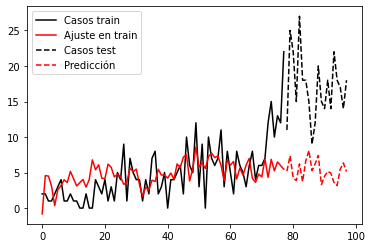

In [59]:
ind_train, ind_test, y_train, y_train_pred, y_test, y_test_pred, coefs = linear_regressor_with(df,8,shuffle=False)

plt.plot(ind_train,y_train, c="k", label="Casos train")
plt.plot(ind_train,y_train_pred, c="r", label = "Ajuste en train")

plt.plot(ind_test,y_test, c="k", linestyle="--", label = "Casos test")
plt.plot(ind_test,y_test_pred, c="r", linestyle="--", label = "Predicción")

plt.legend()

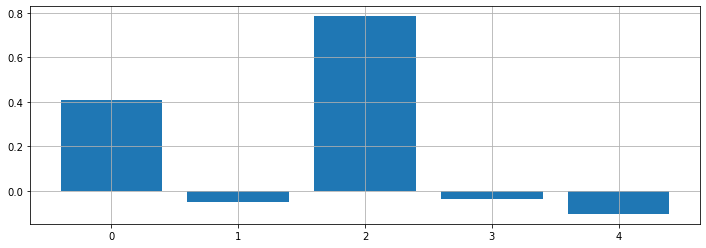

In [ ]:
fig, ax = plt.subplots(figsize = (12,4))
xx = np.arange(coefs.shape[0])
plt.grid()
plt.bar(xx,coefs / coefs.sum())
ax.set_xticks(xx)
plt.show()

In [68]:
X = df[["Temp_Seca_Max","Precipitacion","Temp_Seca_Min","Hum_Rel_Min","Hum_Rel_Max"]].values
y = df["Dengue"].values

n_samples,n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42,
                                                shuffle = False)
    
# x = data["TV"].values.reshape(-1,1)
# y = data["Sales"].values.reshape(-1,1)
est = sm.OLS(y_train,sm.add_constant(X_train))
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     2.885
Date:                Fri, 29 Apr 2022   Prob (F-statistic):             0.0198
Time:                        08:27:56   Log-Likelihood:                -211.52
No. Observations:                  78   AIC:                             435.0
Df Residuals:                      72   BIC:                             449.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.4326     22.870     -1.374      0.174     -77.023      14.158
x1             0.8784      0.378      2.326      0.023       0.126       1.631
x2            -0.1111      0.122     -0.907      0.367      -0.355       0.133
x3             1.6814      0.742      2.267      0.026       0.203       3.160
x4            -0.0836      0.085     -0.986      0.328      -0.253       0.086
x5            -0.2225      0.163     -1.366      0.176      -0.547       0.102
==============================================================================
Omnibus:                       32.192   Durbin-Watson:                   1.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.521
Skew:                           1.389   Prob(JB):                     2.42e-17
Kurtosis:                       6.979   Cond. No.                     5.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""